In [1]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pyfftw as ft
import time
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

In [2]:
N = 1024

In [3]:
Q = np.zeros((N,N,N), dtype='float32')
R = np.zeros((N,N,N), dtype='float32')
S2 = np.zeros((N,N,N), dtype='float32')

In [46]:
start = time.time()

nproc = 8
nx = N//nproc

lQ = np.zeros((N//nproc,N,N), dtype='float32')
lR = np.zeros((N//nproc,N,N), dtype='float32')

t = 0.0
folder = '/home/jhelsas/scratch'

for k in range(nproc):
    filename = 'ref-QR-'+str(k)+'-(t='+str(t)+').npz'
    file = folder+'/'+filename
    
    content = np.load(file)
    lQ[:,:,:] = content['Q']
    lR[:,:,:] = content['R']
    
    Q[k*nx:(k+1)*nx,:,:] = lQ[:,:,:]
    R[k*nx:(k+1)*nx,:,:] = lR[:,:,:]
    
end = time.time()
print(end-start)

15.3138661385


In [5]:
start = time.time()

nproc = 8
nx = N//nproc

lS2 = np.zeros((N//nproc,N,N), dtype='float32')

folder = '/home/jhelsas/scratch'

for k in range(nproc):
    filename = 'ref-strainrate-'+str(k)+'.npz'
    file = folder+'/'+filename
    
    content = np.load(file)
    lS2[:,:,:] = content['S2']
    
    S2[k*nx:(k+1)*nx,:,:] = lS2[:,:,:]
    
end = time.time()
print(end-start)

8.58674788475


In [6]:
del lQ,lR,lS2

In [7]:
avg = np.average(S2)
print(avg)

249.219


In [9]:
avgQ = np.average(Q/avg)
avgR = np.average((R)/avg**(3/2))
avgQ2 = np.average((Q/avg)**2)
Qrms = np.sqrt(avgQ2)
print("<Q>/Q_rms: ",avgQ,"<R>/Q_rms**3: ",avgR,"Q_rms**2: ",avgQ2,"Q_rms : ",Qrms)

('<Q>/Q_rms: ', -1.790994e-10, '<R>/Q_rms**3: ', -1.5522135e-05, 'Q_rms**2: ', 0.28464133, 'Q_rms : ', 0.5335179)


In [10]:
Qf = Q.flatten()
Rf = R.flatten()

In [11]:
hist = np.zeros((N*N*N,2))

In [13]:
hist[:,0] = Rf[:]/(avg**(3/2))
hist[:,1] = Qf[:]/(avg)

In [14]:
lQMin = np.min(hist[:,0])
lQMax = np.max(hist[:,0])
lRMin = np.min(hist[:,1])
lRMax = np.max(hist[:,1])

In [15]:
print(lQMin,lQMax)
print(lRMin,lRMax)
print("Q/Q_rms min,max: ",lQMin,lQMax,"; R/Q_rms^(3/2) min,max: ",lRMin,lRMax)

(-21388.208984375, 22536.45703125)
(-152.81842041015625, 46.078834533691406)
('Q/Q_rms min,max: ', -21388.208984375, 22536.45703125, '; R/Q_rms^(3/2) min,max: ', -152.81842041015625, 46.078834533691406)


In [33]:
lQbinNum = 500
lRbinNum = 500

de = 0.25
lQMin = -25
lQMax = 25
lRMin = -25
lRMax = 25

print("Q/Q_rms min,max: ",lQMin,lQMax,"; R/Q_rms^(3/2) min,max: ",lRMin,lRMax)
print(de)
print(lQbinNum,lRbinNum)

('Q/Q_rms min,max: ', -25, 25, '; R/Q_rms^(3/2) min,max: ', -25, 25)
0.25
(500, 500)


In [34]:
Redges=np.linspace(lQMin,lQMax,lQbinNum)
Qedges=np.linspace(lRMin,lRMax,lRbinNum)

In [38]:
H, qedges, redges = np.histogram2d(Qf[:]/(avg),Rf[:]/(avg**(3/2)), bins=(Redges,Qedges),normed=True)

/home/jhelsas/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


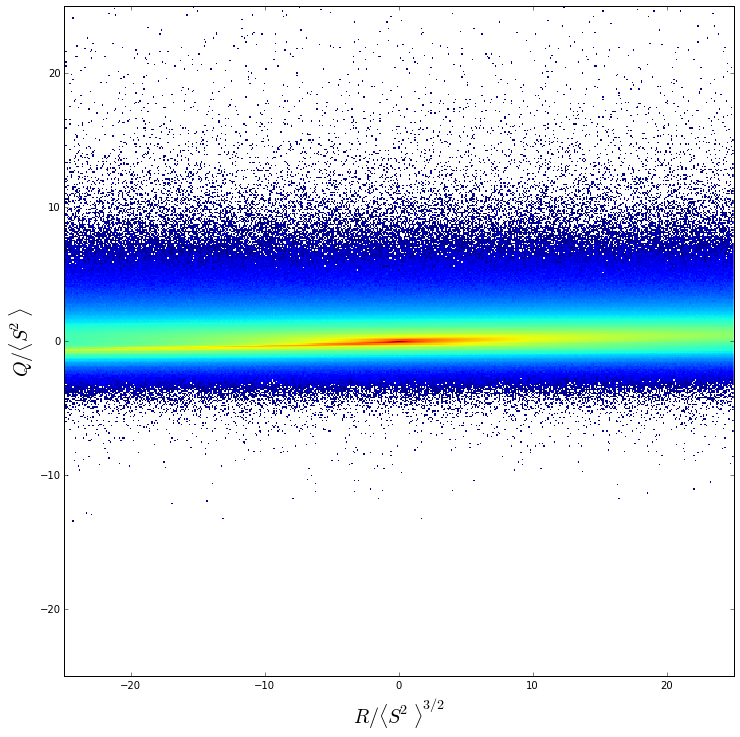

In [45]:
%matplotlib inline 

fig = plt.figure(figsize=(12,12))
logH = np.log(H)/np.log(10)

plt.ylabel(r'$Q/\langle S^2\rangle$',size=20)
plt.xlabel(r'$R/\langle S^2\rangle^{3/2}$',size=20)

cax = plt.imshow(logH,interpolation='none',extent=[-25,25,-25,25],aspect='equal')

#X,Y = np.meshgrid(Redges[0:lRbinNum-1],Qedges[:lQbinNum-1])
#levels=np.logspace(-5.,-1,num=5,base=10.0)
#CS=plt.contour(X,Y,H,levels,colors='k')

plt.savefig('strain-enstr-jpdf-log.pdf', format='pdf', bbox_inches='tight', transparent=True)

In [19]:
Nbins = 1024*8
wtemp = w2[:,:,:] 
w2red=np.zeros(Nbins,dtype='int')
lbins = np.logspace(np.log10(w2Min/avg),np.log10(w2Max/avg),Nbins)
histredw,edgesredw = np.histogram(wtemp/avg,lbins)

In [20]:
Nbins = 1024*8
stemp = S2[:,:,:] 
s2red=np.zeros(Nbins,dtype='int')
lbins = np.logspace(np.log10(s2Min/avg),np.log10(s2Max/avg),Nbins)
histreds,edgesreds = np.histogram(stemp/avg,lbins)

In [21]:
cache = True

if cache:
    np.savez("strainrate-enstrophy-jpdf.npz",H=H,edges=edges,
                                             histredw=histredw,
                                             edgesredw=edgesredw,
                                             histreds=histreds,
                                             edgesreds=edgesreds)

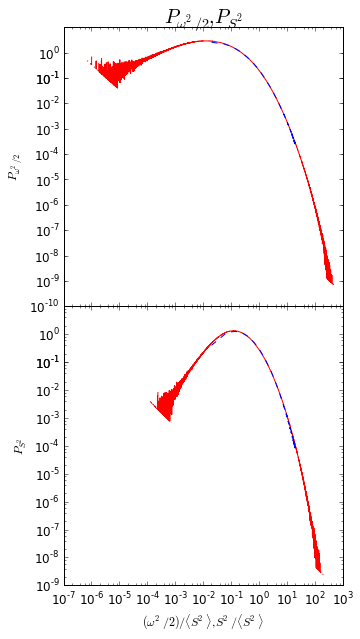

In [22]:
%matplotlib inline 

w2red[-1] = 0
s2red[-1] = 0
w2_bins = np.load('enstrophy_bins.npy')
w2_pdf = np.load('enstrophy_pdf.npy')
s2_bins = np.load('dissipation_bins.npy')
s2_pdf = np.load('dissipation_pdf.npy')
    
fig = plt.figure(figsize=(5,10))

######################################

ax1 = plt.subplot(211)
ax2 = plt.subplot(212,sharex=ax1)

plt.subplots_adjust(hspace=.0)

######################################
    
SIZE = 12
plt.rcParams['figure.figsize'] = (5, 10)
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
ax2.set_xlabel(r'$ (\omega^2/2)/{\langle S^2\rangle},S^2/{\langle S^2\rangle}$')
ax1.set_ylabel(r'$P_{\omega^2/2}$')
ax2.set_ylabel(r'$P_{S^2}$')
plt.setp(ax1.get_xticklabels(), visible=False)

######################################

leftw = edgesredw[0:(Nbins-1)]
rightw = edgesredw[1:Nbins]
normhistw = (histredw*(1024**(-3)))/(rightw-leftw)
normw = np.sum(normhistw*(rightw-leftw))

ax1.set_xlim((10**(-7),10**(3)))
ax1.loglog((leftw+rightw)/2.,normhistw/normw,'r',label='Unfiltered')
ax1.loglog(w2_bins,w2_pdf,'b--')

yticks = [10**(-10),10**(-9),10**(-8),10**(-7),10**(-6),10**(-5),10**(-4),10**(-3),10**(-2),10**(-1),10**(0),10**(-1)]
ax1.set_yticks(yticks)

######################################

lefts = edgesreds[0:(Nbins-1)]
rights = edgesreds[1:Nbins]
normhists = (histreds*(1024**(-3)))/(rights-lefts)
norms = np.sum(normhists*(rights-lefts))

ax2.set_xlim((10**(-7),10**(3)))
ax2.loglog((lefts+rights)/2.,normhists/normw,'r',label='Unfiltered')
ax2.loglog(s2_bins,s2_pdf,'b--')

yticks = [10**(-9),10**(-8),10**(-7),10**(-6),10**(-5),10**(-4),10**(-3),10**(-2),10**(-1),10**(0),10**(-1)]
ax2.set_yticks(yticks)

######################################

ax1.title.set_text(r'$P_{\omega^2/2},P_{S^2}$')
ax1.title.set_size(20)

plt.subplots_adjust(wspace = 0.1)
plt.savefig('strain-enstr-pdfs.pdf', format='pdf', bbox_inches='tight', transparent=True)